In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset

### Load dataset

In [2]:
column_names = ['Attr.1', 'Attr.2', 'Attr.3', 'Attr.4', 'label']
data = pd.read_csv('iris.data',names=column_names, header=None)
data.head(5)

,Attr.1,Attr.2,Attr.3,Attr.4,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### Dataset info.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
Attr.1    150 non-null float64
Attr.2    150 non-null float64
Attr.3    150 non-null float64
Attr.4    150 non-null float64
label     150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


In [4]:
data.describe()

,Attr.1,Attr.2,Attr.3,Attr.4
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
data.groupby('label').size()

label
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64

## Several Functions

### Calculate entropy
$$
H(D) = - \sum_{k=1}^{K} {p_i \log{p_i}} = - \sum_{k=1}^{K}{ \frac{|C_k|}{|D|} \log{\frac{|C_k|}{|D|}} }
$$

**Function: cal_entropy**
- Description: calculate entropy using above formula.
- Patameters: 
    - data: Dataframe type with label and attrbutes as columns.
- Return:
    - entropy: float type

In [6]:
def cal_entropy(data):
    p = data.groupby('label').size() / len(data)
    h = -sum(p * np.log(p))
    return h

### Calculate entropy of the splited set

given split point $s$ of attribute $a$, split $D$ into two disjoint sets $D_1, D_2$, satisfy

$$
D_1 = \{x | x.a <= s\} \\
D_2 = \{x | x.a > s\}
$$

then calculate:

$$
H(D | a, s) = \frac{|D_1|}{|D|}H(D_1) + \frac{|D_2|}{|D|} H(D_2)
$$

**Function: cal_entropy_after_split**
- Description: calculate entropy with the splited data by split_point of attr_name.
- Patameters: 
    - data: Dataframe type with label and attrbutes as columns.
    - attr_name: which is the split_point?
    - split_point: thredhold to split data in attr_name column.
- Return:
    - entropy: float type

In [7]:
def cal_entropy_after_split(data, attr_name, split_point):
    d_1 = data[data[attr_name] <= split_point]
    d_2 = data[data[attr_name] >  split_point]
    h_1 = cal_entropy(d_1)
    h_2 = cal_entropy(d_2)
    h = len(d_1) / len(data) * h_1 + len(d_2) / len(data) * h_2
    return h

### Find best split point

using gold section search algorithm

given $a, b, a < b$, let
$$
\mu = a + (1 - \phi)(b - a) \\
\lambda = a + \phi (b - a)
$$

repeat

if $f(\mu) > f(\lambda)$, then $a = \mu, \mu = \lambda, \lambda = a + \phi (b - a)$

if $f(\mu) < f(\lambda)$, then $b = \lambda, \lambda = \mu, \mu = a + (1 - \phi)(b - a)$

until satisfy the end condition.

$$
s_{best} = \arg { \min_s Criterita(D|a,s)}
$$

criterita may be min_entropy, min_error, min_GINI, etc.

**Function: find_best_split_point**
- Description: find best split point in attr_name column to minimize criterion function
- Patameters: 
    - data: Dataframe type with label and attrbutes as columns.
    - attr_name: in which column?
    - criterion_function: the smaller criteria, the better.
- Return:
    - split_point
- Note: Using gold section search algorithm, maybe fall into minimum if criterion function is not convex function.

In [8]:
def find_best_split_point(data, attr_name, criterion_function):
    fhi = 0.618
    f = criterion_function
    a = min(data[attr_name])
    b = max(data[attr_name])
    mu = a + (1 - fhi) * (b - a)
    lamb = a + fhi * (b - a)
    f_mu = f(data, attr_name, mu)
    f_lambda = f(data, attr_name, lamb)

    while(f_mu != f_lambda):
        if f_mu > f_lambda:
            a = mu
            mu = lamb
            lamb = a + fhi * (b - a)
            f_mu = f_lambda
            f_lambda = f(data, attr_name, lamb)
        else:
            b = lamb
            lamb = mu
            mu = a + (1 - fhi) * (b - a)
            f_lambda = f_mu
            f_mu = f(data, attr_name, mu)
    split_point = (mu + lamb) / 2
    return split_point

In [9]:
split_point = find_best_split_point(data, 'Attr.1', cal_entropy_after_split)
split_point

5.574850320834822

### Can gold section search find optimal split point?

In [10]:
def get_entropy_by_splitpoint(data, attr_name):
    attr_max = max(data[attr_name])
    attr_min = min(data[attr_name])
    entropy = []
    split_point = []
    for i in np.arange(0, attr_max - attr_min, 0.01):
        split_point.append(attr_min + i)
        entropy.append(cal_entropy_after_split(data, attr_name, attr_min + i))
    return entropy, split_point

In [11]:
entropy = []
split_point = []
best_split_point = []
for i in range(1, 5):
    e, s = get_entropy_by_splitpoint(data, 'Attr.%d' % i)
    b_s = find_best_split_point(data, 'Attr.%d' % i, cal_entropy_after_split)
    entropy.append(e)
    split_point.append(s)
    best_split_point.append(b_s)

In [12]:
data_1 = data[data['Attr.1'] <= best_split_point[0]]
entropy_1 = []
split_point_1 = []
best_split_point_1 = []
for i in range(1, 5):
    e, s = get_entropy_by_splitpoint(data_1, 'Attr.%d' % i)
    b_s = find_best_split_point(data_1, 'Attr.%d' % i, cal_entropy_after_split)
    entropy_1.append(e)
    split_point_1.append(s)
    best_split_point_1.append(b_s)

In [13]:
data_2 = data_1[data_1['Attr.2'] <= best_split_point_1[1]]
entropy_2 = []
split_point_2 = []
best_split_point_2 = []
for i in range(1, 5):
    e, s = get_entropy_by_splitpoint(data_2, 'Attr.%d' % i)
    b_s = find_best_split_point(data_2, 'Attr.%d' % i, cal_entropy_after_split)
    entropy_2.append(e)
    split_point_2.append(s)
    best_split_point_2.append(b_s)

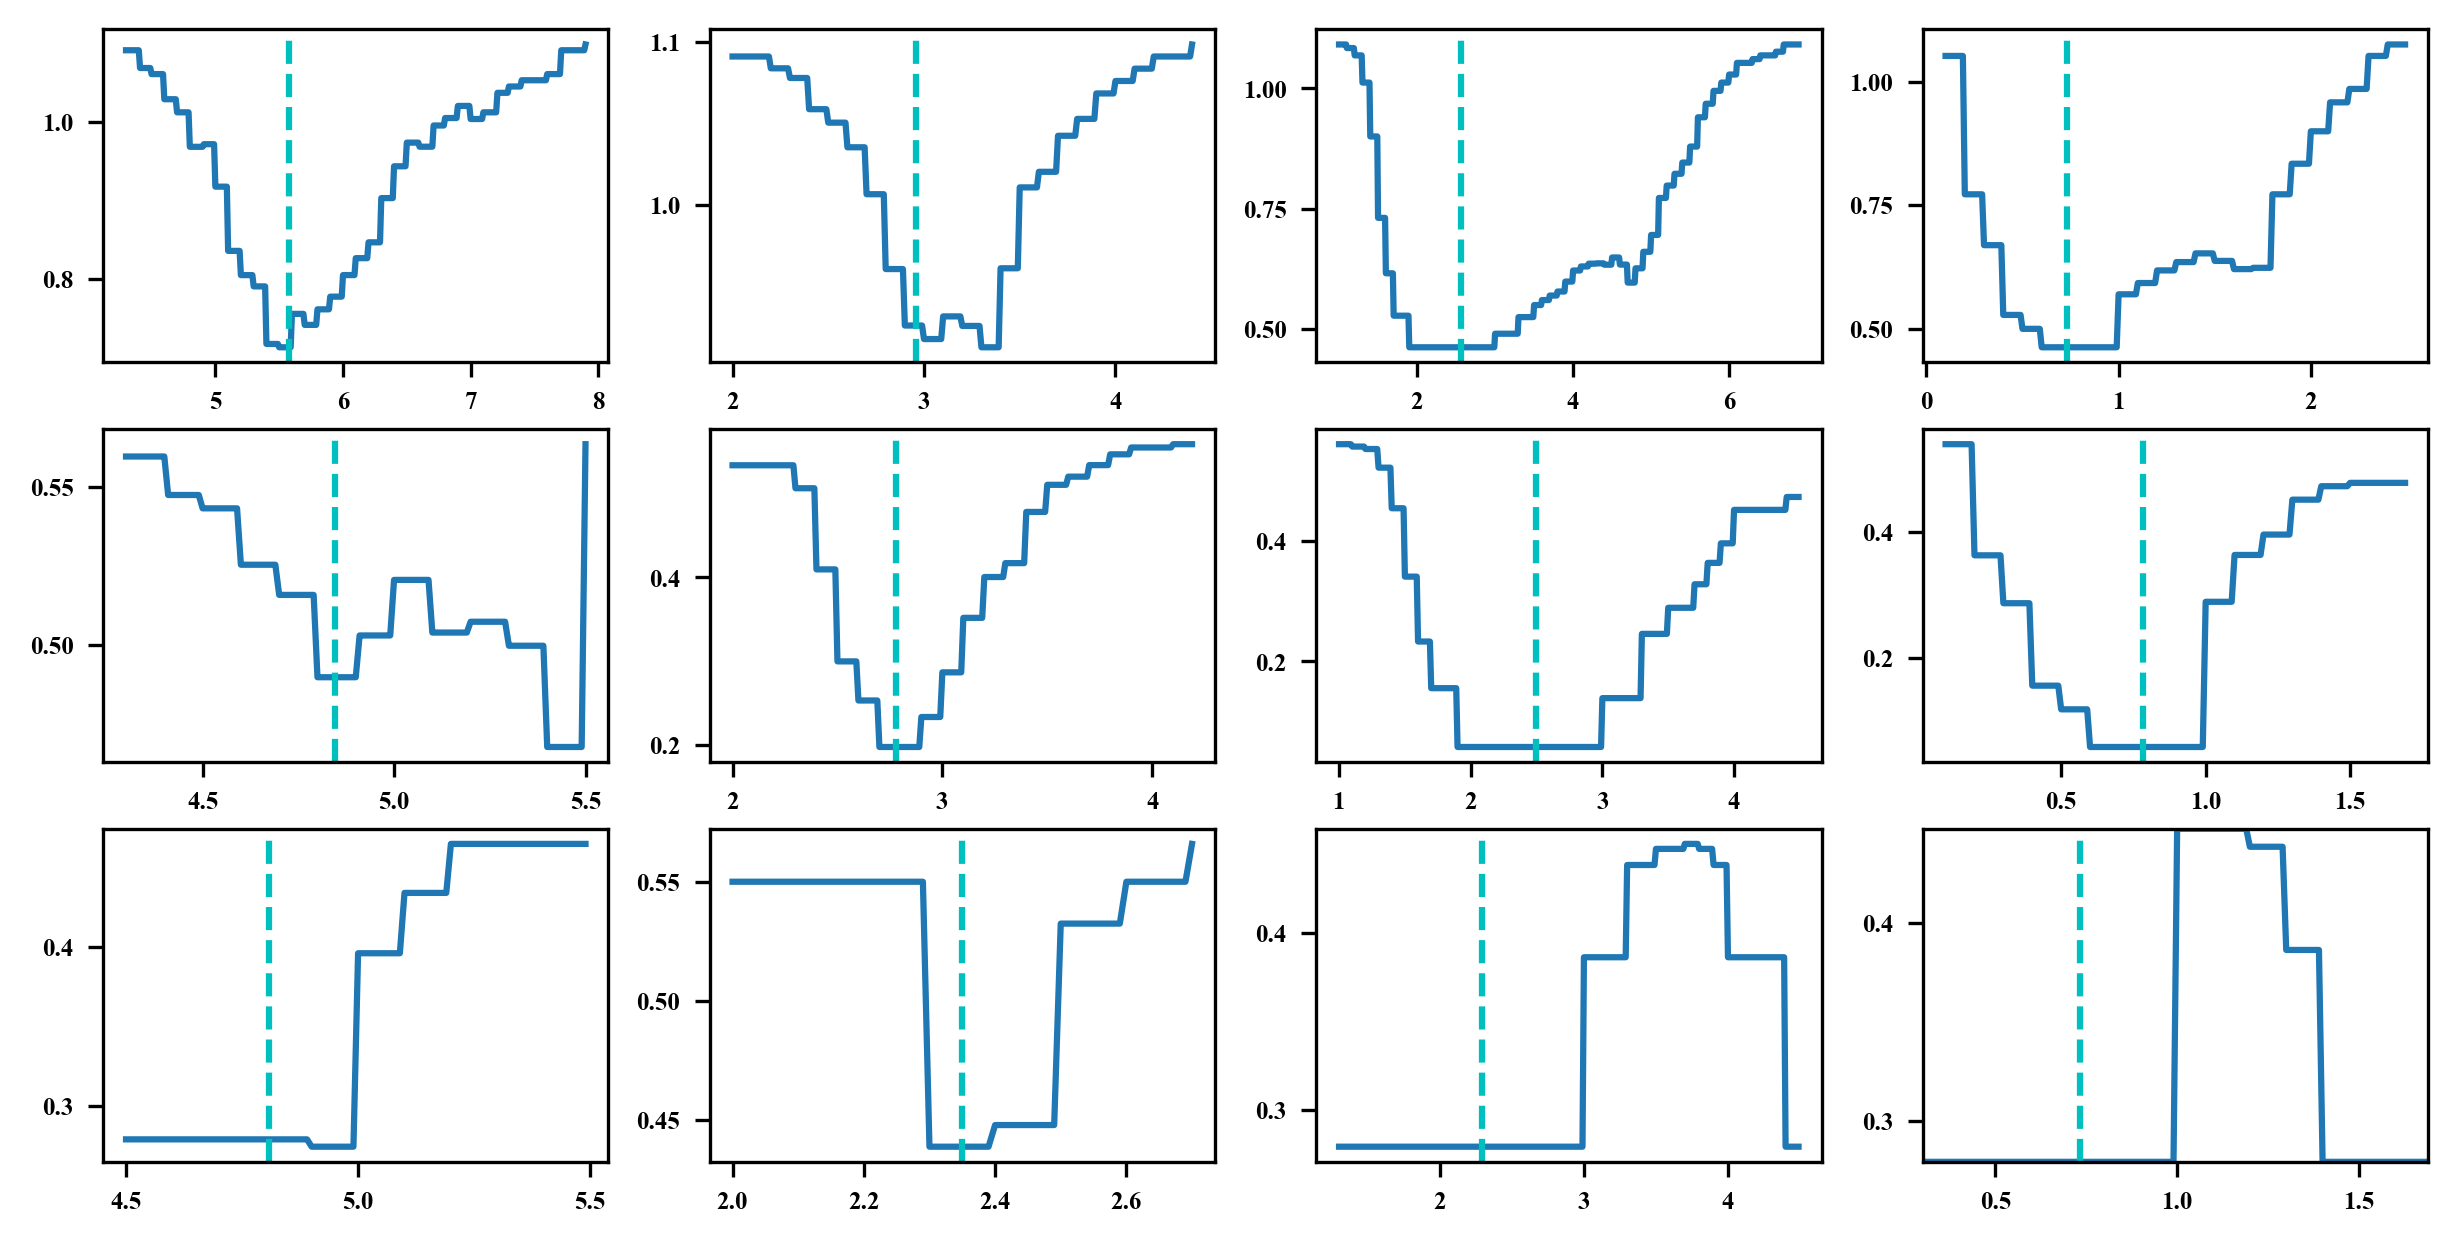

In [14]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

fig = plt.figure(figsize=(10, 5), dpi=300)
for i in range(4):
    ax = fig.add_subplot(3, 4, i + 1)
    plt.plot(split_point[i], entropy[i])
    #plt.xlabel('split point')
    #plt.ylabel('entropy')
    plt.yticks(fontproperties = 'Times New Roman', size = 6)
    plt.xticks(fontproperties = 'Times New Roman', size = 6)
    plt.axvline(x=best_split_point[i], c = "c", ls = "dashed")
    ax = fig.add_subplot(3, 4, i + 5)
    plt.plot(split_point_1[i], entropy_1[i])
    plt.yticks(fontproperties = 'Times New Roman', size = 6)
    plt.xticks(fontproperties = 'Times New Roman', size = 6)
    plt.axvline(x=best_split_point_1[i], c = "c", ls = "dashed")
    ax = fig.add_subplot(3, 4, i + 9)
    plt.plot(split_point_2[i], entropy_2[i])
    plt.yticks(fontproperties = 'Times New Roman', size = 6)
    plt.xticks(fontproperties = 'Times New Roman', size = 6)
    plt.axvline(x=best_split_point_2[i], c = "c", ls = "dashed")

plt.margins(0,0)
plt.savefig('./gss_split_point.jpg', bbox_inches = 'tight')
plt.savefig('./gss_split_point.eps', dpi=300, format='eps', bbox_inches = 'tight')
plt.show()

### Find best attribute

$$
a^* = \arg{\max_{a\in A}{Gain(D|a)}}
$$

**Function: find_best_attribute**
- Description: find best attribute for next branch to maximize gain_function.
- Patameters: 
    - data: Dataframe type with label and attributes as columns.
    - gain_function: the bigger gain, the better.
- Return:
    - best_attr: the best attribute

In [15]:
def find_best_attribute(data, gain_function):
    gain = gain_function
    attr_name_list = data.columns[:-1]
    
    best_attr = attr_name_list[0];
    max_gain = gain(data, best_attr)
    for attr in attr_name_list:
        g = gain(data, attr)
        if max_gain < g:
            best_attr = attr
            max_gain = g
    return best_attr

**Entropy gain:**
$$
Gain(D|a) = H(D) - H(D| a, s)
$$

**Function: entropy_gain**
- Description: calculate entropy gain if using attr as next branch attribute.
- Patameters: 
    - data: Dataframe type with label and attributes as columns.
    - attr: attribute
- Return:
    - gain

In [16]:
def entropy_gain(data, attr):
    old_entropy = cal_entropy(data);
    split_point = find_best_split_point(data, attr, cal_entropy_after_split)
    new_entropy = cal_entropy_after_split(data, attr, split_point)
    gain = old_entropy - new_entropy
    return gain

**Minimum Error Criteria**

predict all samples in $D$ to the label $l$, then error
$$
E(D|l) = \frac{|D(x.label \neq l)|}{|D|}
$$

In [17]:
def cal_error(data):
    label, precise = get_max_precise(data)
    error = 1 - precise
    return error

In [18]:
def cal_error_after_split(data, attr_name, split_point):
    d_1 = data[data[attr_name] <= split_point]
    d_2 = data[data[attr_name] >  split_point]
    error_1 = cal_error(d_1)
    error_2 = cal_error(d_2)
    error = len(d_1) / len(data) * error_1 + len(d_2) / len(data) * error_2
    return error

In [19]:
def error_gain(data, attr):
    old_error = cal_error(data);
    split_point = find_best_split_point(data, attr, cal_error_after_split)
    new_error = cal_error_after_split(data, attr, split_point)
    gain = old_error - new_error
    return gain

**Maximun Entropy Ratio Gain**

$$
Gain\_ratio = \frac{Gain(D|a)}{H(D|a)}
$$

In [20]:
def entropy_ratio_gain(daata, attr):
    pass # need to continue.

**Minimum GINI index criteria**

$$
Gini(D) = 1 - \sum_{k=1}^{|A|}{p_k^2} = 1 - \sum_{k=1}^{K}{\left( \frac{|C_k|}{|D|} \right)^2}
$$

In [21]:
def cal_gini(data):
    p = data.groupby('label').size() / len(data)
    gini = 1 - np.sum(np.power(p, 2))
    return gini

In [22]:
def cal_gini_after_split(data, attr_name, split_point):
    d_1 = data[data[attr_name] <= split_point]
    d_2 = data[data[attr_name] >  split_point]
    error_1 = cal_gini(d_1)
    error_2 = cal_gini(d_2)
    error = len(d_1) / len(data) * error_1 + len(d_2) / len(data) * error_2
    return error

In [23]:
def gini_gain(data, attr):
    old_error = cal_gini(data);
    split_point = find_best_split_point(data, attr, cal_gini_after_split)
    new_error = cal_gini_after_split(data, attr, split_point)
    gain = old_error - new_error
    return gain

### make decision tree

- Algorithm:
    - (1) find the best attribute for next branch.
    - (2) find the best split point of the best brunch attribute.
    - (3) split the data into disjoint subset.
    - (4) then repeat above procedure on these two subset recurrently until santify the end condition.
- End condition:
    - every sample in data has the same label.
- Note: This function may contain some repeated calculations. For example, when we find the best attribute, we have computed the best split point of every attribute, but after find the best attribute we compute the split point of the best attribute again. Although exists some repeated computation, this can maintain the atomic function of each method and easy unstanding of code.

**Function: make_tree**
- Description: make decision tree on data
- Patameters: 
    - data: Dataframe type with label and attributes as columns.
- Return:
    - decision tree:
        - data structure: python build-in dictory. 
            - for example, {'branch_condition1': subtree1,'branch_condition2': subtree2}
        - tree type: binary tree.
        - interal node: branch condition with the form:
            - "attribute_name<=split_point" or "attribute_name>split_point".
        - leaf node: label, string type, 
            - for example: 'Iris-virginica'.

In [24]:
def make_tree(data):
    attr_name_list = data.columns[:-1]
    label_name = data.groupby('label').size().index
    
    if len(label_name) == 1:
        return label_name[0]
    best_attr = find_best_attribute(data, entropy_gain)
    split_point = find_best_split_point(data, best_attr, cal_entropy_after_split)
    tree = {}
    tree['%s<=%f' % (best_attr, split_point)] = make_tree(data[data[best_attr] <= split_point])
    tree['%s>%f' % (best_attr, split_point)] = make_tree(data[data[best_attr] > split_point])
    return tree

In [25]:
tree = make_tree(data)
tree

{'Attr.3<=2.557290': 'Iris-setosa',
 'Attr.3>2.557290': {'Attr.4<=1.749965': {'Attr.3<=4.964518': {'Attr.4<=1.566300': 'Iris-versicolor',
    'Attr.4>1.566300': {'Attr.1<=5.600000': 'Iris-virginica',
     'Attr.1>5.600000': 'Iris-versicolor'}},
   'Attr.3>4.964518': {'Attr.4<=1.550000': 'Iris-virginica',
    'Attr.4>1.550000': {'Attr.1<=6.829154': 'Iris-versicolor',
     'Attr.1>6.829154': 'Iris-virginica'}}},
  'Attr.4>1.749965': {'Attr.3<=4.953220': {'Attr.2<=3.045481': 'Iris-virginica',
    'Attr.2>3.045481': 'Iris-versicolor'},
   'Attr.3>4.953220': 'Iris-virginica'}}}

**Function: predict**
- Description: predict sample's label
- Patameters: 
    - sample: a series with attributes.
    - tree: the tree trained before.
- Return:
    - label

In [26]:
def predict(sample, tree):
    if not isinstance(tree, dict):
        return tree
    
    attr, split_point = list(tree.keys())[0].split('<=')
    split_point = (float)(split_point)
    if sample[attr] <= split_point:
        return predict(sample, tree[list(tree.keys())[0]])
    else:
        return predict(sample, tree[list(tree.keys())[1]])

In [27]:
data.loc[53, :]

Attr.1                5.5
Attr.2                2.3
Attr.3                  4
Attr.4                1.3
label     Iris-versicolor
Name: 53, dtype: object

In [28]:
predict(data.loc[53, :], tree)

'Iris-versicolor'

**Function: evaluate**
- Description: evaluate the performance of the tree on data
- Patameters: 
    - data: Dataframe type with label and attributes as columns.
    - tree: the tree trained before.
- Return:
    - precise: the number of right predicted samples divided by the size of data.

In [29]:
def evaluate(data, tree):
    right_count = 0
    for _, sample in data.T.iteritems():
        label = sample[-1]
        if label == predict(sample, tree):
            right_count += 1
    return right_count / len(data)

In [30]:
evaluate(data, tree)

1.0

**Function: get_max_precise**
- Description: compute the max precise when predict every samples in data to the same label.
- Patameters: 
    - data: Dataframe type with label and attributes as columns.
- Return:
    - label: the label which have max percentage over data.
    - precise: the max precise when see all samples as the same label.

In [31]:
def get_max_precise(data):
    precise_dict = dict(data.groupby('label').size() / len(data))
    if len(precise_dict) == 0:
        return '', 0
    else:
        label = max(precise_dict, key = precise_dict.get)
        precise = precise_dict[label]
        return label, precise

**Function: get_max_precise_after_split**
- Description: compute the precise after split data according to the given split_point of attr.
- Patameters: 
    - data: Dataframe type with label and attributes as columns.
    - attr: attribute name.
    - split_point: split point.
- Return:
    - precise

In [32]:
def get_max_precise_after_split(data, attr, split_point):
    data_1 = data[data[attr] <= split_point]
    data_2 = data[data[attr] >  split_point]
    _, precise_1 = get_max_precise(data_1)
    _, precise_2 = get_max_precise(data_2)
    precise = len(data_1) / len(data) * precise_1 + len(data_2) / len(data) * precise_2
    return precise

### Pre. pruning

- Algorithm:
    - (1) find the best attribute for next branch.
    - (2) compute the best split point of the best attribute.
    - (3) calculate the current precision and the precise on evaluate dataset when we add the next brunch.
    - (4) compare these two precision, if current precision higher, then,
        - stop to brunch, and return the label with the max precision on current dataset.
    - (5) if addition the next brunch is better, then,
        - split the data into disjoint subset according to the split point of the best attribute.
        - then repeat above procedure on these two subset recurrently until santify the end condition.
- End condition:
    - every sample in data has the same label.
    - Over fitting.

**Function: make_tree_with_pre_pruning**
- Description: make decision tree with previous pruning.
- Patameters: 
    - train_set.
    - evaluate_set.
- Return:
    - the pre-pruned tree.

In [33]:
def make_tree_with_pre_pruning(train_set, evaluate_set):
    attr_name_list = train_set.columns[:-1]
    label_name = train_set.groupby('label').size().index
    
    if len(label_name) == 1:
        return label_name[0]
    best_attr = find_best_attribute(train_set, entropy_gain)
    split_point = find_best_split_point(train_set, best_attr, cal_entropy_after_split)
    
    label, precise = get_max_precise(train_set)
    precise_after_split = get_max_precise_after_split(evaluate_set, best_attr, split_point)
    
    if precise >= precise_after_split:
        return label
    else:
        tree = {}
        tree['%s<=%f' % (best_attr, split_point)] = \
                        make_tree_with_pre_pruning(train_set[train_set[best_attr] <= split_point],
                                                   evaluate_set[evaluate_set[best_attr] <= split_point])
        tree['%s>%f' % (best_attr, split_point)] = \
                        make_tree_with_pre_pruning(train_set[train_set[best_attr] > split_point],
                                                  evaluate_set[evaluate_set[best_attr] > split_point])
        return tree

In [34]:
data_shuffled = data.sample(frac=1)
data_shuffled.head(5)

,Attr.1,Attr.2,Attr.3,Attr.4,label
54,6.5,2.8,4.6,1.5,Iris-versicolor
105,7.6,3.0,6.6,2.1,Iris-virginica
47,4.6,3.2,1.4,0.2,Iris-setosa
12,4.8,3.0,1.4,0.1,Iris-setosa
90,5.5,2.6,4.4,1.2,Iris-versicolor


In [35]:
frac = 0.2
train_set = data_shuffled.iloc[0: int(frac * len(data_shuffled)), : ]
evaluate_set = data_shuffled.iloc[int(frac * len(data_shuffled)) : , :]

In [36]:
tree_pre_pruned = make_tree_with_pre_pruning(train_set, evaluate_set)

In [37]:
tree_pre_pruned

{'Attr.1<=5.444352': 'Iris-setosa',
 'Attr.1>5.444352': {'Attr.4<=1.760068': 'Iris-versicolor',
  'Attr.4>1.760068': 'Iris-virginica'}}

In [38]:
evaluate(data, tree_pre_pruned)

0.8866666666666667

### Post. pruning
- Algorithm:
    - (1) split current evaluate_set into two disjoint set according to the brunch condition.
    - (2) prune the two subtree first with corresponding evaluate dataset(using post-order traversal walk through the tree).
    - (3) After prune subtree, calculate the precision on evaluate dataset of current tree and the pruned tree.
    - (4) compare the two precision, if current tree is better, then don't change, return current tree.
    - (5) otherwise, prune current tree by returning the label with maximum percentage.

**Function: post_pruning**
- Description: post-prune tree.
- Patameters: 
    - tree.
    - evaluate_set.
- Return:
    - the post-pruned tree.
- Warning: the original tree will be changed.

In [39]:
def post_pruning(tree, evaluate_set):
    if not isinstance(tree, dict):
        return tree
    
    attr, split_point = list(tree.keys())[0].split('<=')
    split_point = (float)(split_point)
    
    tree[list(tree.keys())[0]] = post_pruning(tree[list(tree.keys())[0]], 
                                              evaluate_set[evaluate_set[attr] <= split_point])
    tree[list(tree.keys())[1]] = post_pruning(tree[list(tree.keys())[1]], 
                                              evaluate_set[evaluate_set[attr] >  split_point])
    
    precise_before_pruning = evaluate(evaluate_set, tree)
    label, precise_after_pruning = get_max_precise(evaluate_set)
    if precise_after_pruning > precise_before_pruning:
        return label
    else:
        return tree

In [40]:
tree = make_tree(data.sample(frac=0.2))
tree

{'Attr.4<=0.818076': 'Iris-setosa',
 'Attr.4>0.818076': {'Attr.3<=4.683165': 'Iris-versicolor',
  'Attr.3>4.683165': 'Iris-virginica'}}

In [41]:
evaluate(data, tree)

0.92

In [42]:
tree_pruned = post_pruning(tree, data.sample(frac=0.6))
tree_pruned

{'Attr.4<=0.818076': 'Iris-setosa',
 'Attr.4>0.818076': {'Attr.3<=4.683165': 'Iris-versicolor',
  'Attr.3>4.683165': 'Iris-virginica'}}

In [43]:
evaluate(data, tree)

0.92

## Wrap into class

In [44]:
class DecisionTree:
    
    def __init__(self, criteria='Entropy'):
        self.criteria = criteria
        self.tree = None
        if criteria == 'Entropy':
            self.gain_function = self._entropy_gain
            self.cal_criterion_after_split = self._cal_entropy_after_split
        elif criteria == 'minError':
            self.gain_function = self._error_gain
            self.cal_criterion_after_split = self._cal_error_after_split
        elif criteria == 'Gini':
            self.gain_function = self._gini_gain
            self.cal_criterion_after_split = self._cal_gini_after_split
            
            
    def make_tree(self, data, ratio = 0.1, pruning='no pruning', max_depth=1024):
        if pruning == 'pre pruning':
            #print('Using pre-prunting.')
            train_set, evaluate_set = self._split_data(data, ratio)
            self.tree = self._make_tree(train_set, max_depth, True, evaluate_set)
        elif pruning == 'post pruning':
            #print('Using post-pruning.')
            train_set, evaluate_set = self._split_data(data, ratio)
            tree = self._make_tree(train_set, max_depth=max_depth)
            self.tree = self._post_pruning(tree, evaluate_set)
        else:
            #print('No pruning.')
            self.tree = self._make_tree(data, max_depth=max_depth)
        
    
    def predict(self, sample):
        return self._predict(sample, self.tree)
    
    
    def evaluate(self, data):
        return self._evaluate(data, self.tree);
    
    
    def _split_data(self, data, frac):
        data = data.sample(frac=1)
        train_set = data.iloc[(int)(len(data) * frac) : , : ]
        evaluate_set = data.iloc[0 : (int)(len(data) * frac), : ]
        return train_set, evaluate_set
        
        
    def _predict(self, sample, tree):
        if not isinstance(tree, dict):
            return tree

        attr, split_point = list(tree.keys())[0].split('<=')
        split_point = (float)(split_point)
        if sample[attr] <= split_point:
            return self._predict(sample, tree[list(tree.keys())[0]])
        else:
            return self._predict(sample, tree[list(tree.keys())[1]])
        
        
    def _evaluate(self, data, tree):
        if len(data) == 0:
            return 1
        
        right_count = 0
        for _, sample in data.T.iteritems():
            label = sample[-1]
            if label == self._predict(sample, tree):
                right_count += 1
        return right_count / len(data)

            
    def _make_tree(self, train_set, max_depth=1024, pre_pruning=False, evaluate_set=None):
        attr_name_list = train_set.columns[:-1]
        label_name = train_set.groupby('label').size().index
        if max_depth == 0:
            label, precise = self._get_max_precise(train_set)
            return label
        
        if len(label_name) == 0:
            return ''
        
        if len(label_name) == 1:
            return label_name[0]
        
        best_attr = self._find_best_attribute(train_set, self.gain_function)
        split_point = self._find_best_split_point(train_set, best_attr, self.cal_criterion_after_split)
        
        if len(train_set.groupby(best_attr).size()) == 1:
            label, precise = self._get_max_precise(train_set)
            return label
        tree = {}
        if pre_pruning:
            label, precise = self._get_max_precise(train_set)
            precise_after_split = self._get_max_precise_after_split(evaluate_set, best_attr, split_point)

            if precise >= precise_after_split:
                return label
            tree['%s<=%f' % (best_attr, split_point)] = \
                            self._make_tree(train_set[train_set[best_attr] <= split_point], max_depth - 1, True,
                                                       evaluate_set[evaluate_set[best_attr] <= split_point])
            tree['%s>%f' % (best_attr, split_point)] = \
                            self._make_tree(train_set[train_set[best_attr] > split_point], max_depth - 1, True,
                                                      evaluate_set[evaluate_set[best_attr] >  split_point])
        else:
            tree['%s<=%f' % (best_attr, split_point)] = \
                            self._make_tree(train_set[train_set[best_attr] <= split_point], max_depth - 1)
            tree['%s>%f' % (best_attr, split_point)] = \
                            self._make_tree(train_set[train_set[best_attr] >  split_point], max_depth - 1)
        return tree
        
        
    def _post_pruning(self, tree, evaluate_set):
        if not isinstance(tree, dict):
            return tree

        attr, split_point = list(tree.keys())[0].split('<=')
        split_point = (float)(split_point)

        tree[list(tree.keys())[0]] = self._post_pruning(tree[list(tree.keys())[0]], 
                                                  evaluate_set[evaluate_set[attr] <= split_point])
        tree[list(tree.keys())[1]] = self._post_pruning(tree[list(tree.keys())[1]], 
                                                  evaluate_set[evaluate_set[attr] >  split_point])

        precise_before_pruning = self._evaluate(evaluate_set, tree)
        label, precise_after_pruning = self._get_max_precise(evaluate_set)
        if precise_after_pruning > precise_before_pruning:
            return label
        else:
            return tree

        
    def _find_best_split_point(self, data, attr_name, criterion_function):
        fhi = 0.618
        f = criterion_function
        a = min(data[attr_name])
        b = max(data[attr_name])
        mu = a + (1 - fhi) * (b - a)
        lamb = a + fhi * (b - a)
        f_mu = f(data, attr_name, mu)
        f_lambda = f(data, attr_name, lamb)

        while(f_mu != f_lambda):
            if f_mu > f_lambda:
                a = mu
                mu = lamb
                lamb = a + fhi * (b - a)
                f_mu = f_lambda
                f_lambda = f(data, attr_name, lamb)
            else:
                b = lamb
                lamb = mu
                mu = a + (1 - fhi) * (b - a)
                f_lambda = f_mu
                f_mu = f(data, attr_name, mu)
        split_point = (mu + lamb) / 2
        return split_point
        
        
    def _find_best_attribute(self, data, gain_function):
        gain = gain_function
        attr_name_list = data.columns[:-1]

        best_attr = attr_name_list[0];
        max_gain = gain(data, best_attr)
        for attr in attr_name_list:
            g = gain(data, attr)
            if max_gain < g:
                best_attr = attr
                max_gain = g
        return best_attr

    
    def _get_max_precise(self, data):
        precise_dict = dict(data.groupby('label').size() / len(data))
        if len(precise_dict) == 0:
            return '', 0
        else:
            label = max(precise_dict, key = precise_dict.get)
            precise = precise_dict[label]
            return label, precise
    
    
    def _get_max_precise_after_split(self, data, attr, split_point):
        if len(data) == 0:
            return 0
        data_1 = data[data[attr] <= split_point]
        data_2 = data[data[attr] >  split_point]
        _, precise_1 = self._get_max_precise(data_1)
        _, precise_2 = self._get_max_precise(data_2)
        precise = len(data_1) / len(data) * precise_1 + len(data_2) / len(data) * precise_2
        return precise
        
        
    def _cal_entropy(self, data):
        p = data.groupby('label').size() / len(data)
        h = -sum(p * np.log(p))
        return h
    
    
    def _cal_entropy_after_split(self, data, attr_name, split_point):
        d_1 = data[data[attr_name] <= split_point]
        d_2 = data[data[attr_name] >  split_point]
        h_1 = self._cal_entropy(d_1)
        h_2 = self._cal_entropy(d_2)
        h = len(d_1) / len(data) * h_1 + len(d_2) / len(data) * h_2
        return h
    
    
    def _entropy_gain(self, data, attr):
        old_entropy = self._cal_entropy(data);
        split_point = self._find_best_split_point(data, attr, 
                                            self._cal_entropy_after_split)
        new_entropy = self._cal_entropy_after_split(data, attr, split_point)
        gain = old_entropy - new_entropy
        return gain
    
    
    def _cal_error(self, data):
        _, precise = self._get_max_precise(data)
        error = 1 - precise
        return error
    
    
    def _cal_error_after_split(self, data, attr_name, split_point):
        d_1 = data[data[attr_name] <= split_point]
        d_2 = data[data[attr_name] >  split_point]
        error_1 = self._cal_error(d_1)
        error_2 = self._cal_error(d_2)
        error = len(d_1) / len(data) * error_1 + len(d_2) / len(data) * error_2
        return error
    
    def _error_gain(self, data, attr):
        old_error = self._cal_error(data);
        split_point = self._find_best_split_point(data, attr, 
                                                  self._cal_error_after_split)
        new_error = self._cal_error_after_split(data, attr, split_point)
        gain = old_error - new_error
        return gain
    
    
    def _cal_gini(self, data):
        p = data.groupby('label').size() / len(data)
        gini = 1 - np.sum(np.power(p, 2))
        return gini
    
    
    def _cal_gini_after_split(self, data, attr_name, split_point):
        d_1 = data[data[attr_name] <= split_point]
        d_2 = data[data[attr_name] >  split_point]
        error_1 = self._cal_error(d_1)
        error_2 = self._cal_error(d_2)
        error = len(d_1) / len(data) * error_1 + len(d_2) / len(data) * error_2
        return error
    
    
    def _gini_gain(self, data, attr):
        old_error = self._cal_gini(data);
        split_point = self._find_best_split_point(data, attr, 
                                                  self._cal_gini_after_split)
        new_error = self._cal_gini_after_split(data, attr, split_point)
        gain = old_error - new_error
        return gain

In [45]:
decision_tree = DecisionTree(criteria='minError')

In [46]:
decision_tree.make_tree(data.sample(frac=0.6), data.sample(frac=0.4),  pruning='no pruning', max_depth=6)

In [47]:
decision_tree.evaluate(data)

0.96

## Evaluate DT

### cross evaluation

In [48]:
def cross_validation(model, k, data, pruning):
    distance = int(len(data) / k)
    accuracy = []
    for begin in range(0, len(data), distance):
        evaluate_set = data.iloc[begin : begin + distance, :]
        train_set = pd.concat([data.iloc[0:begin, :], data.iloc[begin + distance:, :]])
        model.make_tree(train_set, pruning=pruning)
        
        acc = model.evaluate(evaluate_set)
        accuracy.append(acc)
    avg_acc = sum(accuracy) / len(accuracy)
    
    return avg_acc, accuracy

In [49]:
data_shuffled = data.sample(frac=1)

In [50]:
model = DecisionTree('Gini')

In [51]:
cross_validation(model, 5, data_shuffled, 'post pruning')

(0.9333333333333333, [0.9, 0.9, 1.0, 0.9666666666666667, 0.9])

### Overfitting

In [52]:
data_shuffled = data.sample(frac=1)

In [53]:
 def split_data(data, frac):
    data = data.sample(frac=1)
    train_set = data.iloc[(int)(len(data) * frac) : , : ]
    evaluate_set = data.iloc[0 : (int)(len(data) * frac), : ]
    return train_set, evaluate_set

In [54]:
train_set, evaluate_set = split_data(data_shuffled, 0.3)

In [55]:
len(train_set)

105

In [56]:
len(evaluate_set)

45

In [57]:
depth = []
train_precise = []
evaluate_precise = []
tree = DecisionTree('Entropy')
for d in range(1, 7):
    tree.make_tree(train_set, max_depth=d, pruning='no pruning')
    t_p = tree.evaluate(train_set)
    e_p = tree.evaluate(evaluate_set)
    depth.append(d)
    train_precise.append(t_p)
    evaluate_precise.append(e_p)

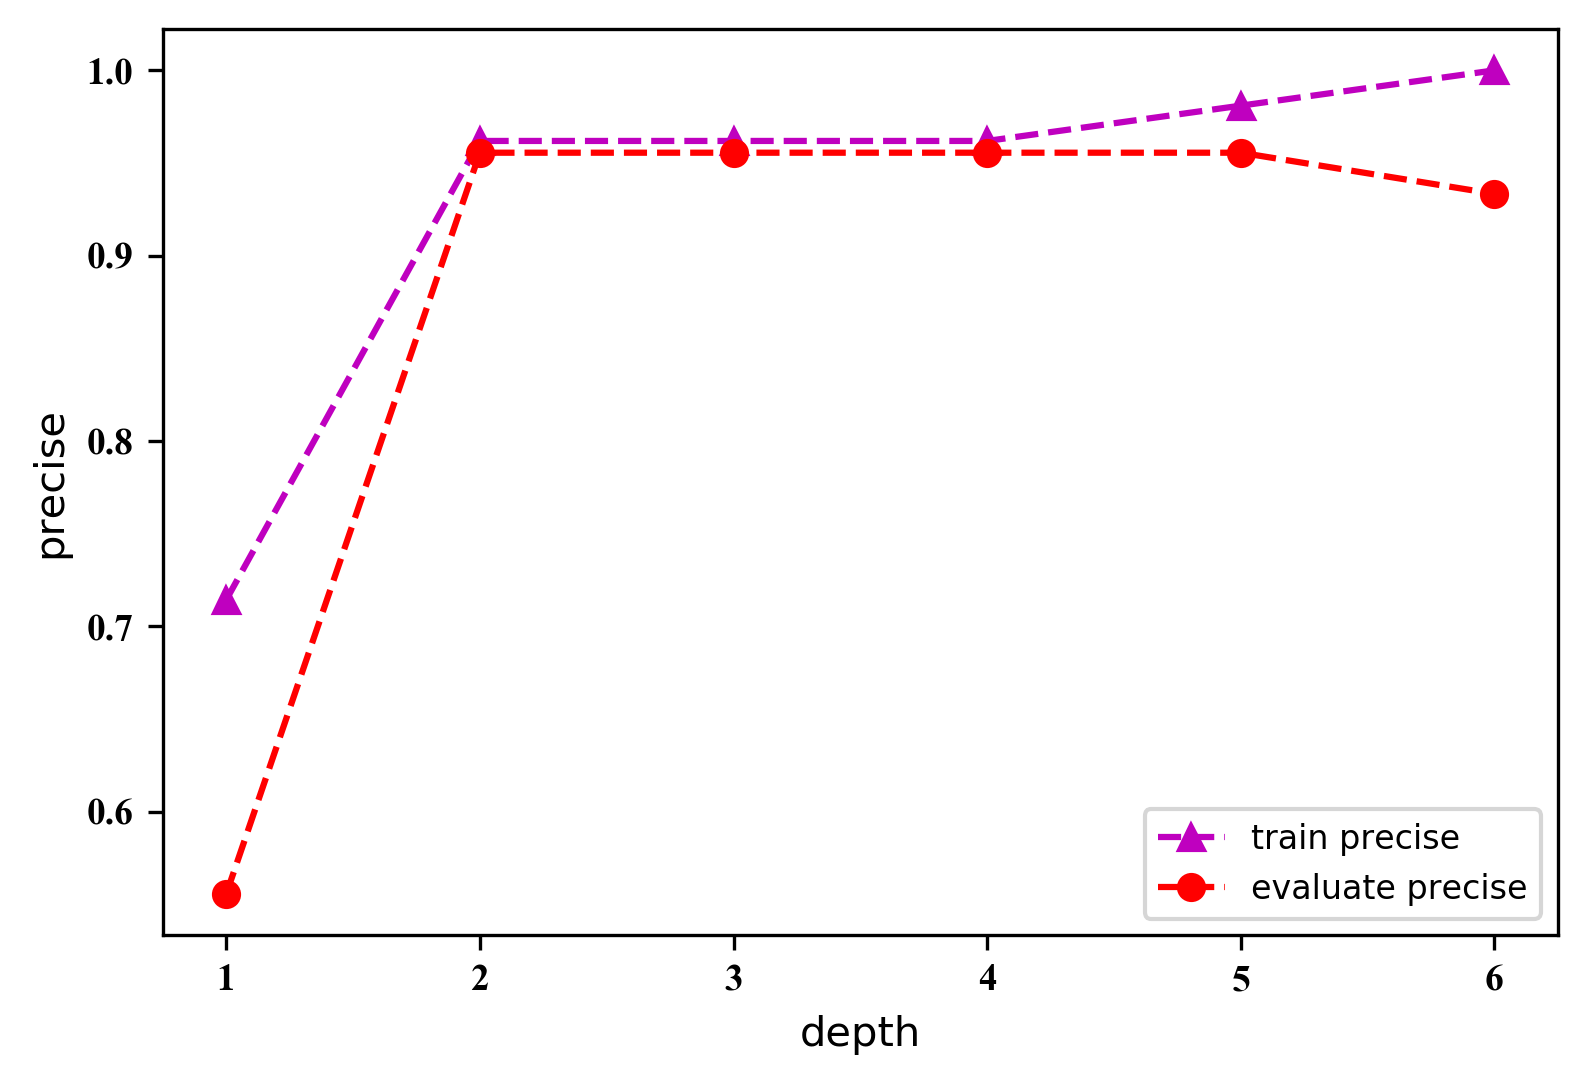

In [58]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

plt.plot(depth, train_precise, 'm^--', label='train precise')
plt.plot(depth, evaluate_precise, 'ro--', label='evaluate precise')
plt.xlabel('depth')
plt.ylabel('precise')
plt.yticks(fontproperties = 'Times New Roman', size = 9)
plt.xticks(fontproperties = 'Times New Roman', size = 9)
plt.legend(fontsize=8)
#plt.savefig('./overfitting.jpg')
#plt.savefig('./overfitting.eps', dpi=300, format='eps')
plt.show()

### Can pruning prevent overfitting?

In [59]:
tree = DecisionTree('Entropy')
pre_max_precise, _ = cross_validation(tree, 4, data_shuffled, 'pre pruning')
post_max_precise, _ = cross_validation(tree, 4, data_shuffled, 'post pruning')
no_max_precise, _ = cross_validation(tree, 4, data_shuffled, 'no pruning')

In [60]:
pre_max_precise, post_max_precise, no_max_precise

(0.9459459459459459, 0.9459459459459459, 0.9459459459459459)

In [61]:
tree.make_tree(train_set, pruning='no pruning')
no_precise = tree.evaluate(evaluate_set)
tree.make_tree(train_set, pruning='pre pruning')
pre_precise = tree.evaluate(evaluate_set)
tree.make_tree(train_set, pruning='post pruning')
post_precise = tree.evaluate(evaluate_set)

In [62]:
no_precise, pre_precise, post_precise

(0.9333333333333333, 0.9555555555555556, 0.9555555555555556)

### preformance by different criteria

In [63]:
depth = []
entropy_train_precise = []
error_train_precise = []
gini_train_precise = []
entropy_evaluate_precise = []
error_evaluate_precise = []
gini_evaluate_precise = []
entropy_tree = DecisionTree('Entropy')
error_tree = DecisionTree('minError')
gini_tree = DecisionTree('Gini')
for d in range(1, 8):
    entropy_tree.make_tree(train_set, max_depth=d, pruning='no pruning')
    error_tree.make_tree(train_set, max_depth=d, pruning='no pruning')
    gini_tree.make_tree(train_set, max_depth=d, pruning='no pruning')
    en_t_p = entropy_tree.evaluate(train_set)
    en_e_p = entropy_tree.evaluate(evaluate_set)
    er_t_p = error_tree.evaluate(train_set)
    er_e_p = error_tree.evaluate(evaluate_set)
    gi_t_p = gini_tree.evaluate(train_set)
    gi_e_p = gini_tree.evaluate(evaluate_set)
    depth.append(d)
    entropy_train_precise.append(en_t_p)
    entropy_evaluate_precise.append(en_e_p)
    error_train_precise.append(er_t_p)
    error_evaluate_precise.append(er_e_p)
    gini_train_precise.append(gi_t_p)
    gini_evaluate_precise.append(gi_e_p)

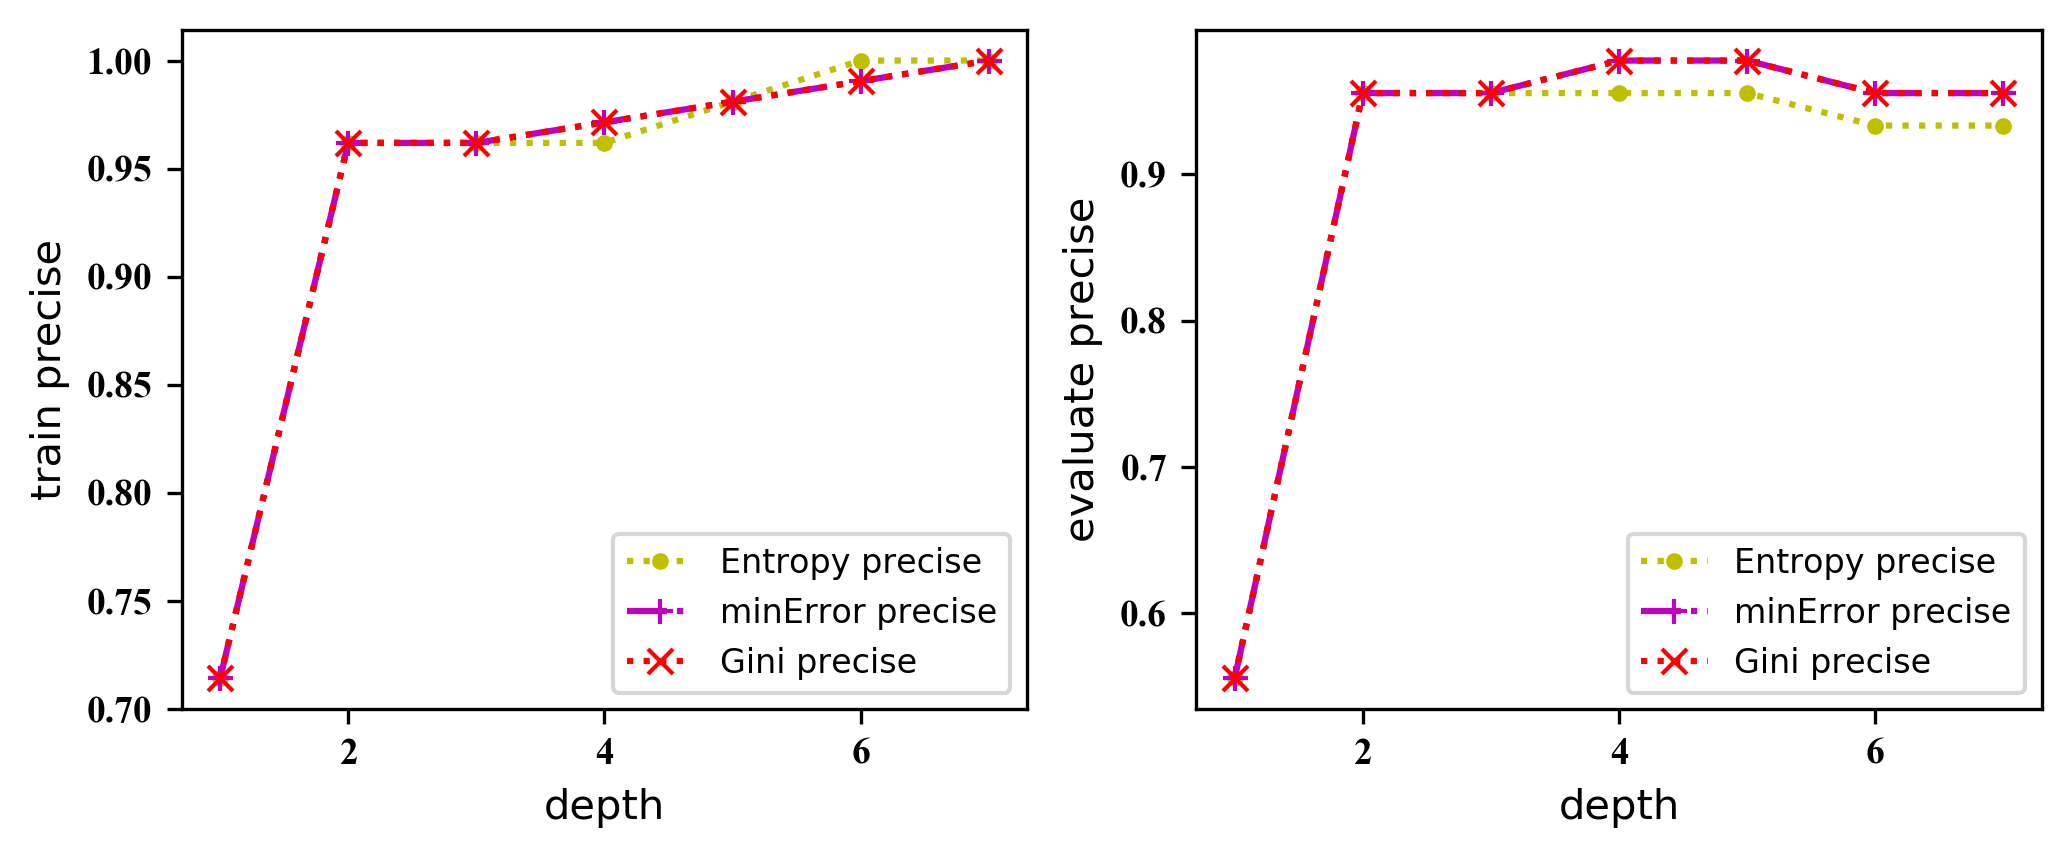

In [64]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

fig = plt.figure(figsize=(8, 3), dpi=300)
ax0 = fig.add_subplot(1, 2, 1)
ax0.plot(depth, entropy_train_precise, 'y.:', label='Entropy precise')
ax0.plot(depth, error_train_precise, 'm+-.', label='minError precise')
ax0.plot(depth, gini_train_precise, 'rx:', label='Gini precise')
plt.xlabel('depth')
plt.ylabel('train precise')

plt.yticks(fontproperties = 'Times New Roman', size = 9)
plt.xticks(fontproperties = 'Times New Roman', size = 9)
plt.legend(fontsize=8)
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(depth, entropy_evaluate_precise, 'y.:', label='Entropy precise')
ax1.plot(depth, error_evaluate_precise, 'm+-.', label='minError precise')
ax1.plot(depth, gini_evaluate_precise, 'rx:', label='Gini precise')
plt.xlabel('depth')
plt.ylabel('evaluate precise')

plt.yticks(fontproperties = 'Times New Roman', size = 9)
plt.xticks(fontproperties = 'Times New Roman', size = 9)
plt.legend(fontsize=8)
#plt.savefig('./precise_vs_criteria.jpg')
#plt.savefig('./precise_vs_criteria.eps', dpi=300, format='eps')
plt.show()

In [65]:
entropy_tree = DecisionTree('Entropy')
error_tree = DecisionTree('minError')
gini_tree = DecisionTree('Gini')

In [66]:
entropy_precise, _ = cross_validation(entropy_tree, 5, data_shuffled, 'no pruning')
error_precise, _ = cross_validation(error_tree, 5, data_shuffled, 'no pruning')
gini_precise, _ = cross_validation(gini_tree, 5, data_shuffled, 'no pruning')

In [67]:
entropy_precise, error_precise, gini_precise

(0.9533333333333334, 0.9333333333333332, 0.9333333333333332)

### Something went wrong!

In [68]:
index = [72, 133, 56, 87]

In [69]:
test_data = data_shuffled.loc[index]
test_data

,Attr.1,Attr.2,Attr.3,Attr.4,label
72,6.3,2.5,4.9,1.5,Iris-versicolor
133,6.3,2.8,5.1,1.5,Iris-virginica
56,6.3,3.3,4.7,1.6,Iris-versicolor
87,6.3,2.3,4.4,1.3,Iris-versicolor


In [70]:
find_best_attribute(test_data, error_gain)

'Attr.1'

In [71]:
find_best_split_point(test_data, 'Attr.3', cal_error_after_split)

4.75

In [72]:
cal_error_after_split(test_data, 'Attr.1', 6.3)

0.25

### Show how decision works

In [73]:
label_name_list = list(data.groupby('label').size().index)
attr_name_list = list(data.columns[:-1])

In [74]:
def split_data(data):
    data_ = []
    for i in range(len(label_name_list)):
        data_.append(data[data['label'] == label_name_list[i]])
    attr_data = []
    for i in range(len(data_)):
        temp_data = []
        for j in range(len(attr_name_list)):
            temp_data.append(data_[i].iloc[:,j])
        attr_data.append(temp_data)
    return attr_data

In [75]:
def plot_sub_scatter(attr_data, i, j):
    plt.scatter(attr_data[0][i], attr_data[0][j], c='c', s=3, label=label_name_list[0])
    plt.scatter(attr_data[1][i], attr_data[1][j], c='g', s=3, label=label_name_list[1])
    plt.scatter(attr_data[2][i], attr_data[2][j], c='b', s=3, label=label_name_list[2])
    plt.xlabel('$Attr.%d$' % (i + 1), fontsize=6)
    plt.ylabel('$Attr.%d$' % (j + 1), fontsize=6)
    plt.yticks(fontproperties = 'Times New Roman', size = 6)
    plt.xticks(fontproperties = 'Times New Roman', size = 6)
    plt.legend(loc=1, fontsize=6)

In [76]:
def plot_scatter(attr_data, attr_name, split_point, save_name=None):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300

    fig = plt.figure(figsize=(10, 6), dpi=300)
    fig.add_subplot(2, 3, 1)
    plot_sub_scatter(attr_data, 0, 1)
    if attr_name == 'Attr.1':
        plt.axvline(x=split_point, c = "y", ls = "dashed")
    elif attr_name == 'Attr.2':
        plt.axhline(y=split_point, c = "y", ls = "dashed")
        
    fig.add_subplot(2, 3, 2)
    plot_sub_scatter(attr_data, 0, 2)
    if attr_name == 'Attr.1':
        plt.axvline(x=split_point, c = "y", ls = "dashed")
    elif attr_name == 'Attr.3':
        plt.axhline(y=split_point, c = "y", ls = "dashed")

    fig.add_subplot(2, 3, 3)
    plot_sub_scatter(attr_data, 0, 3)
    if attr_name == 'Attr.1':
        plt.axvline(x=split_point, c = "y", ls = "dashed")
    elif attr_name == 'Attr.4':
        plt.axhline(y=split_point, c = "y", ls = "dashed")
        
    fig.add_subplot(2, 3, 4)
    plot_sub_scatter(attr_data, 1, 2)
    if attr_name == 'Attr.2':
        plt.axvline(x=split_point, c = "y", ls = "dashed")
    elif attr_name == 'Attr.3':
        plt.axhline(y=split_point, c = "y", ls = "dashed")
        
    fig.add_subplot(2, 3, 5)
    plot_sub_scatter(attr_data, 1, 3)
    if attr_name == 'Attr.2':
        plt.axvline(x=split_point, c = "y", ls = "dashed")
    elif attr_name == 'Attr.4':
        plt.axhline(y=split_point, c = "y", ls = "dashed")
        
    fig.add_subplot(2, 3, 6)
    plot_sub_scatter(attr_data, 2, 3)
    if attr_name == 'Attr.3':
        plt.axvline(x=split_point, c = "y", ls = "dashed")
    elif attr_name == 'Attr.4':
        plt.axhline(y=split_point, c = "y", ls = "dashed")
        
    if save_name is not None:
        plt.savefig(save_name + '.jpg', bbox_inches = 'tight')
        plt.savefig(save_name + '.eps', dpi=300, format='eps', bbox_inches = 'tight')
    plt.show()

In [77]:
attr_data = split_data(data)

In [78]:
best_attribute = find_best_attribute(data, entropy_gain)
split_point = find_best_split_point(data, best_attribute, cal_entropy_after_split)
best_attribute, split_point

('Attr.3', 2.5572901556)

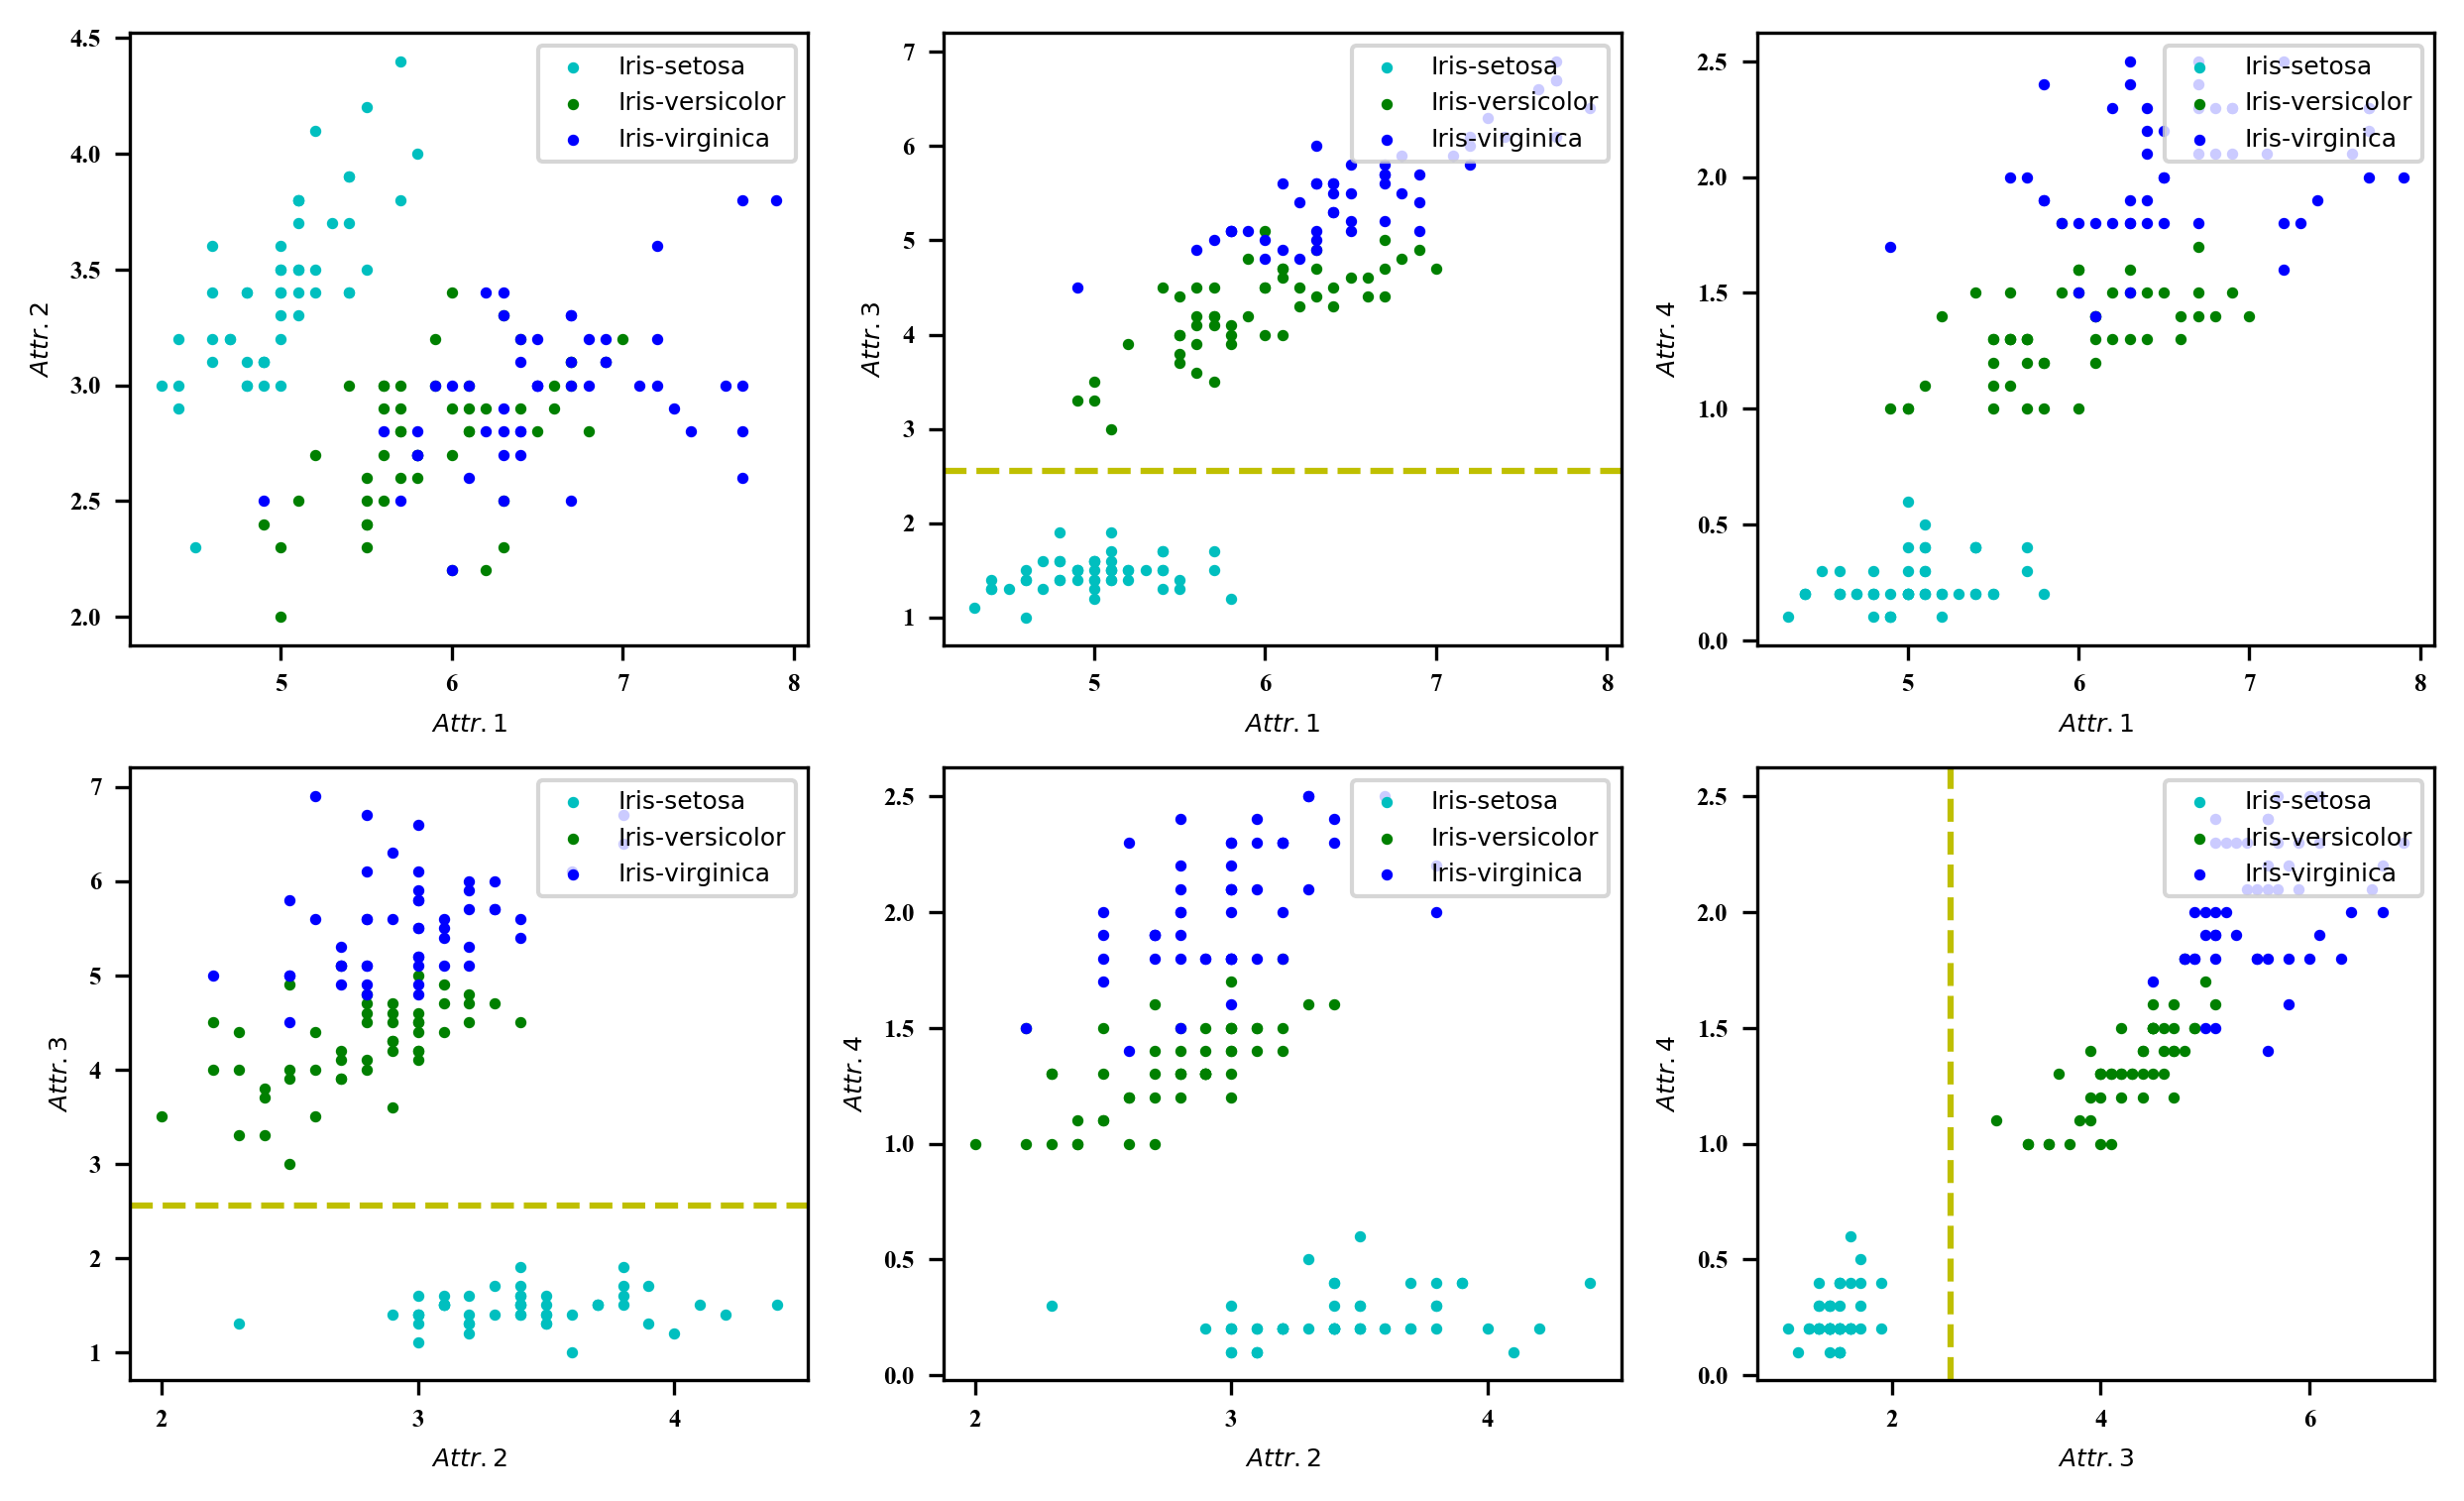

In [79]:
plot_scatter(attr_data, best_attribute, split_point)
                                         #, 'attr_scatter_depth_1')

In [80]:
data_1 = data[data[best_attribute] > split_point]
attr_data = split_data(data_1)
best_attribute = find_best_attribute(data_1, entropy_gain)
split_point = find_best_split_point(data_1, best_attribute, cal_entropy_after_split)
best_attribute, split_point

('Attr.4', 1.749964774)

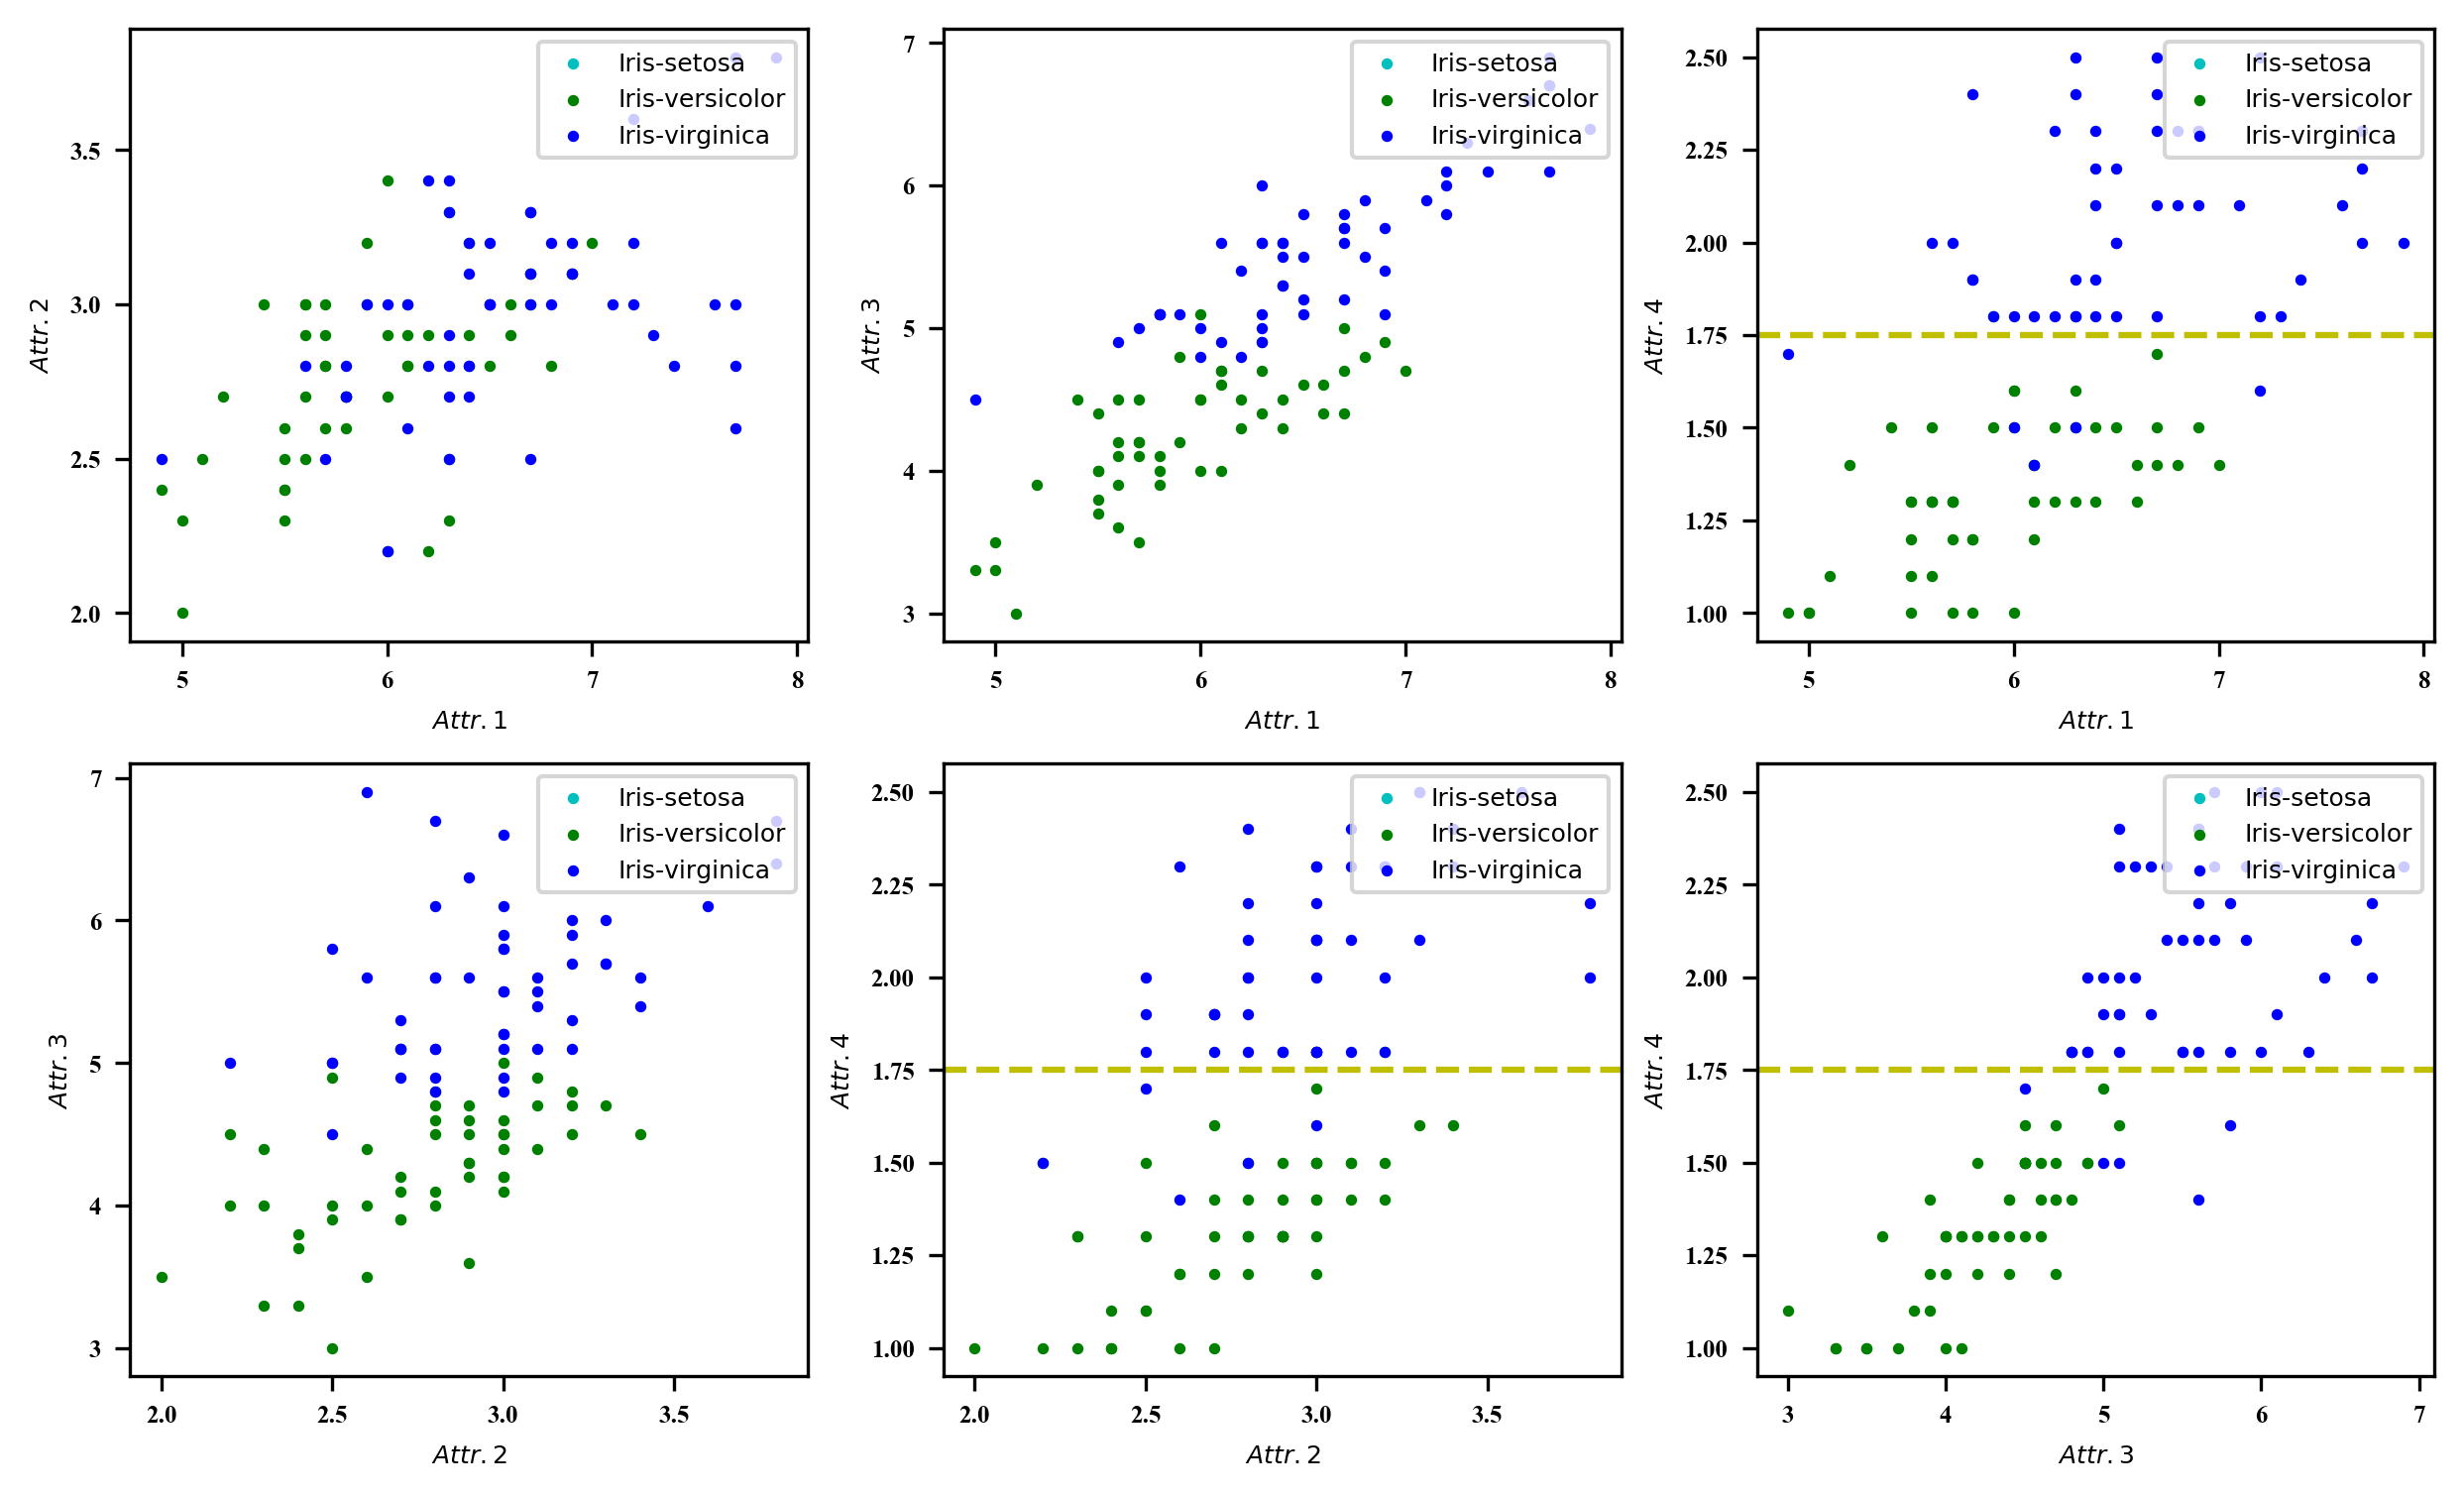

In [81]:
plot_scatter(attr_data, best_attribute, split_point)
                                         #, 'attr_scatter_depth_2')

In [82]:
data_2 = data_1[data_1[best_attribute] <= split_point]
attr_data = split_data(data_2)
best_attribute = find_best_attribute(data_2, entropy_gain)
split_point = find_best_split_point(data_2, best_attribute, cal_entropy_after_split)
best_attribute, split_point

('Attr.3', 4.964518196849209)

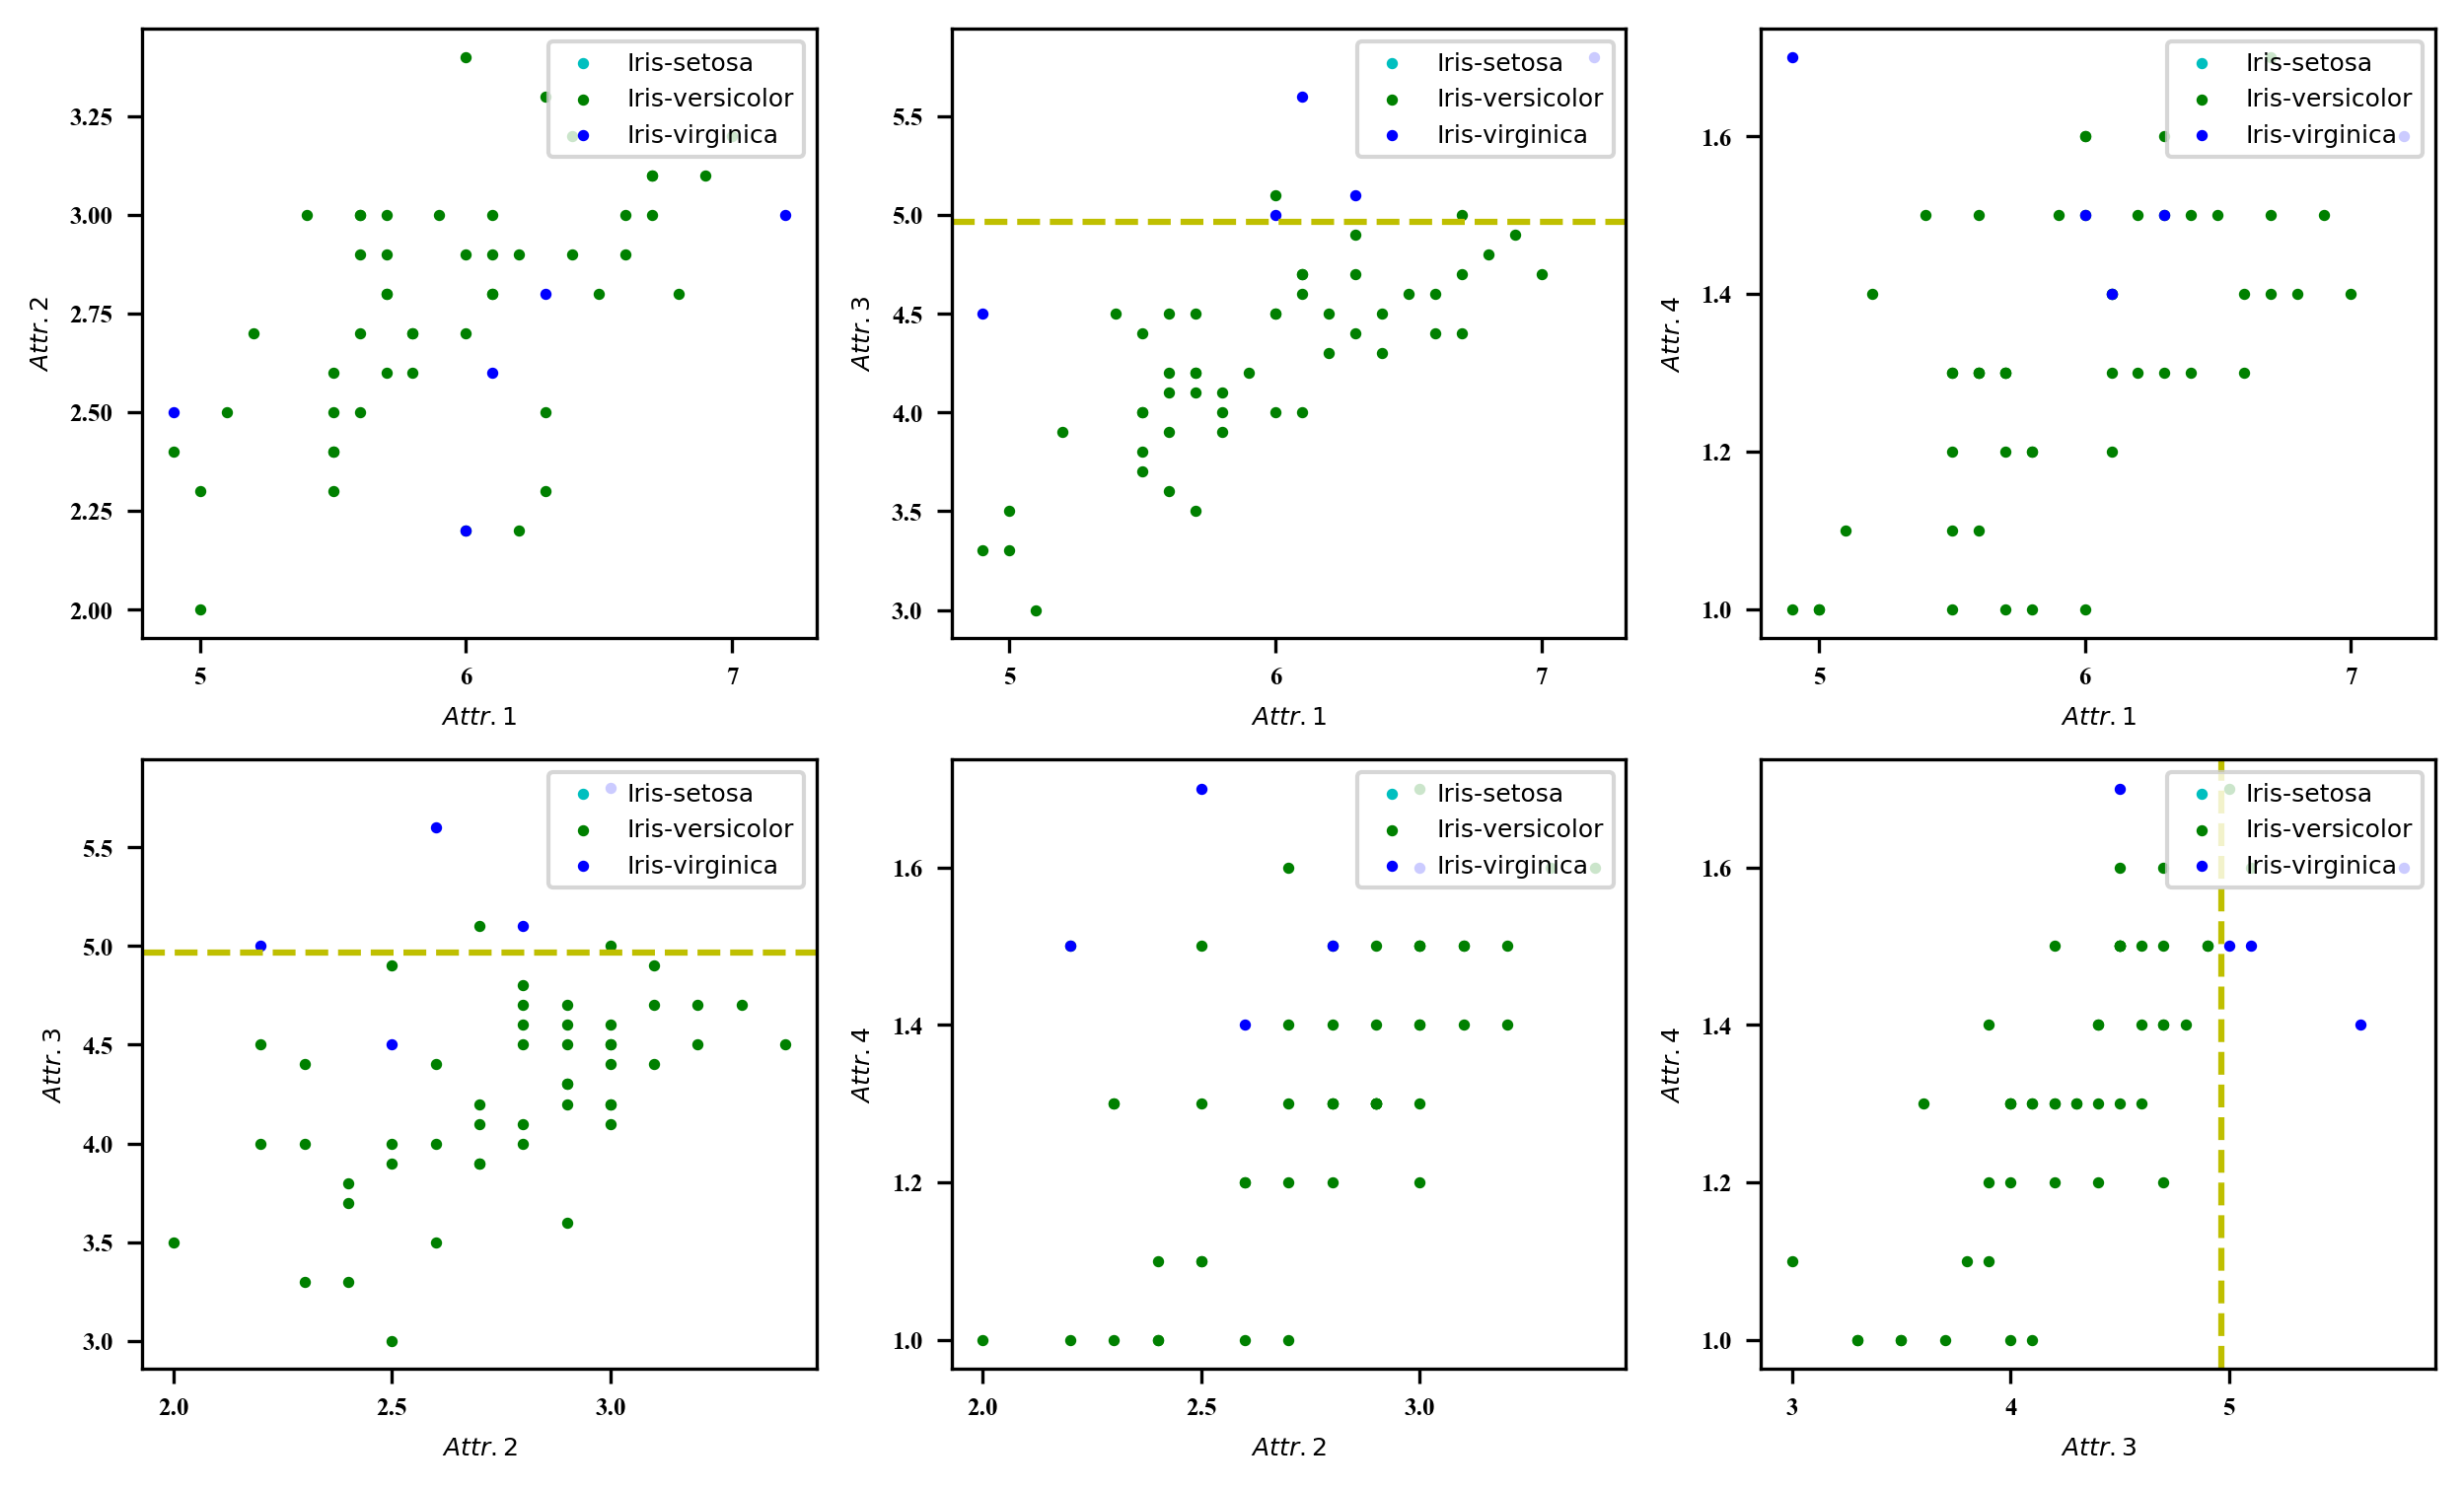

In [83]:
plot_scatter(attr_data, best_attribute, split_point)
                                        #, 'attr_scatter_depth_3')